# Project Overview: Wine Quality Classification (SVM)
### Problem Definition

##### The goal of this project is to predict the quality of red wine based on its physicochemical properties (e.g., acidity, sugar, pH, alcohol).
##### The dataset winequality-red.csv comes from the UCI Machine Learning Repository.

##### Each record represents a wine sample tested in a Portuguese wine lab, with 11 numeric input variables and one quality score (integer between 3 and 8).

##### Our goal is to build an SVM-based classification model that automatically categorizes each wine into one of three classes:
| Category | Description | Label |
| :- | :- | :- |
| Low | Quality ≤ 5 | 0 |
| Medium | Quality = 6 | 1 |
| High | Quality ≥ 7 | 2 |

### Objectives
- Preprocess and clean the dataset.
- Transform numeric quality into categorical labels.
- Train a baseline SVM model using default parameters.
- Optimize the model via GridSearchCV to find the best hyperparameters.
- Compare both models using Accuracy, Precision, Recall, F1-score, and ROC AUC.
- Display results using a confusion matrix and text reports.
  

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset Features
| Feature | Description |
| :- | :- |
| fixed acidity | nonvolatile acids |
| volatile acidity | acetic acid content |
| citric acid | citric acid level |
| residual sugar | sugar after fermentation |
| chlorides | salt content |
| free sulfur dioxide | free SO₂ gas |
| total sulfur dioxide | total SO₂ content |
| density | liquid density |
| pH | acidity/basicity |
| sulphates | wine preservation compound |
| alcohol | alcohol percentage |

### Load Data 

In [9]:
df = pd.read_csv(r".\data\winequality-red.csv")
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8      

### Create target classes (Low=0, Medium=1, High=2) 

In [10]:
def categorize_quality(q):
    if q <= 5:
        return 0
    elif q == 6:
        return 1
    else:
        return 2

df["quality_class"] = df["quality"].apply(categorize_quality)
X = df.drop(["quality", "quality_class"], axis=1)
y = df["quality_class"]


### Split Train/Test 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scale Data 

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline SVM

In [14]:
baseline_svm = SVC()
baseline_svm.fit(X_train_scaled, y_train)
y_pred_base = baseline_svm.predict(X_test_scaled)

### Baseline Evaluation

In [15]:
acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, average='weighted')
rec_base = recall_score(y_test, y_pred_base, average='weighted')
f1_base = f1_score(y_test, y_pred_base, average='weighted')
print("\n--- Baseline Evaluation ---")
print("Accuracy:", acc_base)
print("Precision:", prec_base)
print("Recall:", rec_base)
print("F1:", f1_base)
print("\nClassification Report:\n", classification_report(y_test, y_pred_base))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_base))


--- Baseline Evaluation ---
Accuracy: 0.690625
Precision: 0.6964259607351713
Recall: 0.690625
F1: 0.6822460937500001

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78       149
           1       0.62      0.62      0.62       128
           2       0.81      0.40      0.53        43

    accuracy                           0.69       320
   macro avg       0.72      0.62      0.64       320
weighted avg       0.70      0.69      0.68       320

Confusion Matrix:
 [[124  24   1]
 [ 45  80   3]
 [  2  24  17]]


### Hyperparameter Tuning 

In [16]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("\n--- Best Hyperparameters ---")
print(grid.best_params_)

best_svm = grid.best_estimator_


--- Best Hyperparameters ---
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


### Tuned Model Evaluation 

In [17]:
y_pred_tuned = best_svm.predict(X_test_scaled)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
rec_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
print("\n--- Tuned Evaluation ---")
print("Accuracy:", acc_tuned)
print("Precision:", prec_tuned)
print("Recall:", rec_tuned)
print("F1:", f1_tuned)
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


--- Tuned Evaluation ---
Accuracy: 0.69375
Precision: 0.6898478205430006
Recall: 0.69375
F1: 0.6906518966620145

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.77       149
           1       0.64      0.59      0.61       128
           2       0.68      0.63      0.65        43

    accuracy                           0.69       320
   macro avg       0.68      0.67      0.68       320
weighted avg       0.69      0.69      0.69       320

Confusion Matrix:
 [[120  28   1]
 [ 41  75  12]
 [  1  15  27]]


### ROC AUC (multiclass)

In [18]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = best_svm.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
print("\nROC AUC:", roc_auc)


ROC AUC: 0.8259114564769668


### Confusion Matrix Visualization

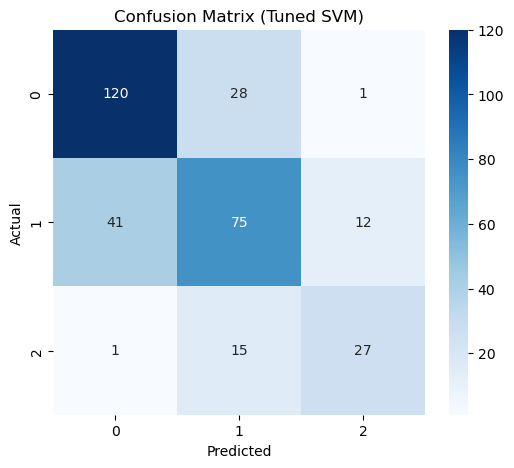

In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Tuned SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Comparison Summary 

In [20]:
print("\n--- Model Comparison ---")
print(f"{'Metric':<12} {'Baseline':<12} {'Tuned':<12}")
print(f"{'Accuracy':<12} {acc_base:<12.4f} {acc_tuned:<12.4f}")
print(f"{'Precision':<12} {prec_base:<12.4f} {prec_tuned:<12.4f}")
print(f"{'Recall':<12} {rec_base:<12.4f} {rec_tuned:<12.4f}")
print(f"{'F1':<12} {f1_base:<12.4f} {f1_tuned:<12.4f}")


--- Model Comparison ---
Metric       Baseline     Tuned       
Accuracy     0.6906       0.6937      
Precision    0.6964       0.6898      
Recall       0.6906       0.6937      
F1           0.6822       0.6907      


### Baseline vs Tuned SVM (Wine Quality Dataset)
| Metric | Baseline | Tuned | Interpretation |
| :- | :- | :- | :- |
| Accuracy | 0.6906 | 0.6937 | Almost identical — tuning gave a very small gain. |
| Precision | 0.6964 | 0.6898 | Slight drop (insignificant, trade-off for better balance). |
| Recall | 0.6906 | 0.6937 | Slight increase — the tuned model catches a few more samples correctly. |
| F1-score | 0.6822 | 0.6907 | Small but consistent improvement — better harmonic mean of precision and recall. |
| ROC AUC | ~0.82 (after tuning) | — | Shows good overall class separation ability. |

#### Interpretation
- Both models perform around 69–70% accuracy, which is realistic for this dataset. The wine quality data is noisy and subjective, meaning physicochemical features can’t perfectly predict human-rated “quality”.
- Tuning slightly improved balance (F1) and ROC AUC, suggesting the optimized parameters allowed the SVM to generalize a bit better.
- Class 0 (low quality) is detected best — that’s expected because it has the largest support.
- Class 1 (medium) and class 2 (high) overlap in feature space, which makes them harder to separate.